In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out import create_dir
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.point_clouds.ae_templates import conv_architecture_ala_nips_17, default_train_params_ala_nips_17
from tf_lab.point_clouds.encoders_decoders import encoder_with_convs_and_symmetry, decoder_with_fc_only
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet

from tf_lab.in_out.basics import Data_Splitter
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
n_pc_points = 2048
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
top_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_points))
train_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_small_size_splits/train.txt')
val_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_small_size_splits/val.txt')

In [4]:
do_training = True
load_pretrained_model = False
load_epoch = None
random_seed = 42
splitter = Data_Splitter(top_pclouds_path, data_file_ending='.ply', random_seed=42)

In [5]:
bneck_size = 256
loss = 'chamfer'
experiment_id = '1'

In [9]:
experiment_name = '_'.join(['wu_small', experiment_id, str(n_pc_points),
                            'pts_bneck', str(bneck_size), loss
                           ])

train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/testing_ae_settings', experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/wu_small_1_2048_pts_bneck_256_chamfer'

In [10]:
tr_files = splitter.load_splits(train_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(tr_files, n_threads=40, loader=snc_loader, verbose=True)
train_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)

val_files = splitter.load_splits(val_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(val_files, n_threads=40, loader=snc_loader, verbose=True)
val_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)

3500 pclouds were loaded. They belong in 7 shape-classes.
350 pclouds were loaded. They belong in 7 shape-classes.


In [29]:
default_train_params_ala_nips_17()

def architectures_to_test(bneck, bnorm, neighborhood):
    res = dict()

    res['encoder_args'] = {'filter_sizes': [neighborhood, min(neighborhood, 20), 10, 5],
                           'n_filters': [64, 128, 256, bneck],
                           'strides': [1, 1, 2, 2],
                           'b_norm': bnorm
                          }
    
    res['decoder_args'] = {'layer_sizes': [1024, 2048, 6144],
                           'b_norm': bnorm
                          }
    return res

In [30]:
arc_param = architectures_to_test(bneck_size, False, 10)

In [31]:
if load_pretrained_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
    if conf.train_dir != train_dir:
        conf.train_dir = train_dir
    conf.save(osp.join(train_dir, 'configuration'))
else:
    conf = Conf(
                n_input = [n_pc_points, 3],
                loss = loss,
                training_epochs = 100,
                batch_size = 50,
                denoising = False,
                learning_rate = 0.0005,
                train_dir = train_dir,             
                loss_display_step = 1,
                saver_step = 10,
                z_rotate = False,
                encoder = encoder_with_convs_and_symmetry,
                decoder = decoder_with_fc_only,
                encoder_args = arc_param['encoder_args'],
                decoder_args = arc_param['decoder_args'],
               )
    
    conf.experiment_name = experiment_name
    conf.held_out_step = 5
    conf.save(osp.join(conf.train_dir, 'configuration'))

In [32]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)

In [19]:
if load_pretrained_model:
    if load_epoch is None: # load last saved.
        saved_epochs = read_saved_epochs(conf.train_dir)
        load_epoch = saved_epochs[-1]        
    ae.restore_model(conf.train_dir, load_epoch, verbose=True)

In [33]:
if do_training:
    buf_size = 1 # flush each line
    fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)    
    train_stats = ae.train(train_data, conf, log_file=fout, held_out_data=val_data)
    fout.close()

('Epoch:', '0001', 'training time (minutes)=', '0.0605', 'loss=', '0.007054574')
INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/wu_small_1_2048_pts_bneck_256_chamfer/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/wu_small_1_2048_pts_bneck_256_chamfer/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0002', 'training time (minutes)=', '0.0592', 'loss=', '0.002501663')
('Epoch:', '0003', 'training time (minutes)=', '0.0597', 'loss=', '0.001701769')
('Epoch:', '0004', 'training time (minutes)=', '0.0592', 'loss=', '0.001516148')
('Epoch:', '0005', 'training time (minutes)=', '0.0595', 'loss=', '0.001342192')
('Held Out Data :', 'forward time (minutes)=', '0.0018', 'loss=', '0.001368445')
('Epoch:', '0006', 'training time (minutes)=', '0.0597', 'loss=', '0.001233118')
('Epoch:', '0007', 'training time (minutes)=', '0.0602', 'loss=', '0.001161133')
('Epoch:', '0008', 'training time (minutes)=', '0.0597', 'loss=', '0.001114744')
('Epoch:', '0009', 'training time (minutes)=', '0.0598', 'loss=', '0.001042674')
('Epoch:', '0010', 'training time (minutes)=', '0.0601', 'loss=', '0.001001314')
INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/wu_small_1_2048_pts_bneck_256_chamfer/models.ckpt-10 is not in all_model_checkpoint_paths. Manually ad

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/wu_small_1_2048_pts_bneck_256_chamfer/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0018', 'loss=', '0.001132294')
('Epoch:', '0011', 'training time (minutes)=', '0.0603', 'loss=', '0.000956231')
('Epoch:', '0012', 'training time (minutes)=', '0.0606', 'loss=', '0.000976214')
('Epoch:', '0013', 'training time (minutes)=', '0.0605', 'loss=', '0.000959531')
('Epoch:', '0014', 'training time (minutes)=', '0.0611', 'loss=', '0.000932220')
('Epoch:', '0015', 'training time (minutes)=', '0.0643', 'loss=', '0.000860587')
('Held Out Data :', 'forward time (minutes)=', '0.0019', 'loss=', '0.001040511')
('Epoch:', '0016', 'training time (minutes)=', '0.0640', 'loss=', '0.000845874')
('Epoch:', '0017', 'training time (minutes)=', '0.0606', 'loss=', '0.000854680')
('Epoch:', '0018', 'training time (minutes)=', '0.0613', 'loss=', '0.000834376')
('Epoch:', '0019', 'training time (minutes)=', '0.0630', 'loss=', '0.000786827')
('Epoch:', '0020', 'training time (minutes)=', '0.0642', 'loss=', '0.000781352')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/wu_small_1_2048_pts_bneck_256_chamfer/models.ckpt-20 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0021', 'loss=', '0.001008347')
('Epoch:', '0021', 'training time (minutes)=', '0.0650', 'loss=', '0.000774619')
('Epoch:', '0022', 'training time (minutes)=', '0.0660', 'loss=', '0.000775269')
('Epoch:', '0023', 'training time (minutes)=', '0.0634', 'loss=', '0.000782700')
('Epoch:', '0024', 'training time (minutes)=', '0.0657', 'loss=', '0.000743323')
('Epoch:', '0025', 'training time (minutes)=', '0.0606', 'loss=', '0.000713507')
('Held Out Data :', 'forward time (minutes)=', '0.0017', 'loss=', '0.001020196')
('Epoch:', '0026', 'training time (minutes)=', '0.0618', 'loss=', '0.000697903')
('Epoch:', '0027', 'training time (minutes)=', '0.0651', 'loss=', '0.000700617')
('Epoch:', '0028', 'training time (minutes)=', '0.0610', 'loss=', '0.000685791')
('Epoch:', '0029', 'training time (minutes)=', '0.0629', 'loss=', '0.000682376')
('Epoch:', '0030', 'training time (minutes)=', '0.0649', 'loss=', '0.000671986')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/wu_small_1_2048_pts_bneck_256_chamfer/models.ckpt-30 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0019', 'loss=', '0.000962777')
('Epoch:', '0031', 'training time (minutes)=', '0.0626', 'loss=', '0.000676017')
('Epoch:', '0032', 'training time (minutes)=', '0.0612', 'loss=', '0.000674471')
('Epoch:', '0033', 'training time (minutes)=', '0.0643', 'loss=', '0.000680858')
('Epoch:', '0034', 'training time (minutes)=', '0.0639', 'loss=', '0.000694209')
('Epoch:', '0035', 'training time (minutes)=', '0.0643', 'loss=', '0.000681398')
('Held Out Data :', 'forward time (minutes)=', '0.0018', 'loss=', '0.000976407')
('Epoch:', '0036', 'training time (minutes)=', '0.0640', 'loss=', '0.000653182')
('Epoch:', '0037', 'training time (minutes)=', '0.0627', 'loss=', '0.000656546')
('Epoch:', '0038', 'training time (minutes)=', '0.0646', 'loss=', '0.000652129')
('Epoch:', '0039', 'training time (minutes)=', '0.0610', 'loss=', '0.000650335')
('Epoch:', '0040', 'training time (minutes)=', '0.0627', 'loss=', '0.000653114')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/wu_small_1_2048_pts_bneck_256_chamfer/models.ckpt-40 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0019', 'loss=', '0.000985518')
('Epoch:', '0041', 'training time (minutes)=', '0.0609', 'loss=', '0.000610717')
('Epoch:', '0042', 'training time (minutes)=', '0.0660', 'loss=', '0.000601827')
('Epoch:', '0043', 'training time (minutes)=', '0.0609', 'loss=', '0.000584940')
('Epoch:', '0044', 'training time (minutes)=', '0.0634', 'loss=', '0.000624320')
('Epoch:', '0045', 'training time (minutes)=', '0.0669', 'loss=', '0.000618708')
('Held Out Data :', 'forward time (minutes)=', '0.0019', 'loss=', '0.000988964')
('Epoch:', '0046', 'training time (minutes)=', '0.0638', 'loss=', '0.000580055')
('Epoch:', '0047', 'training time (minutes)=', '0.0637', 'loss=', '0.000563903')
('Epoch:', '0048', 'training time (minutes)=', '0.0608', 'loss=', '0.000550275')
('Epoch:', '0049', 'training time (minutes)=', '0.0657', 'loss=', '0.000553588')
('Epoch:', '0050', 'training time (minutes)=', '0.0624', 'loss=', '0.000550764')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/wu_small_1_2048_pts_bneck_256_chamfer/models.ckpt-50 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0018', 'loss=', '0.000953810')
('Epoch:', '0051', 'training time (minutes)=', '0.0620', 'loss=', '0.000537097')
('Epoch:', '0052', 'training time (minutes)=', '0.0673', 'loss=', '0.000538884')
('Epoch:', '0053', 'training time (minutes)=', '0.0628', 'loss=', '0.000533880')
('Epoch:', '0054', 'training time (minutes)=', '0.0643', 'loss=', '0.000553387')
('Epoch:', '0055', 'training time (minutes)=', '0.0606', 'loss=', '0.000544950')
('Held Out Data :', 'forward time (minutes)=', '0.0021', 'loss=', '0.000970720')
('Epoch:', '0056', 'training time (minutes)=', '0.0607', 'loss=', '0.000535258')
('Epoch:', '0057', 'training time (minutes)=', '0.0623', 'loss=', '0.000527093')
('Epoch:', '0058', 'training time (minutes)=', '0.0678', 'loss=', '0.000512947')
('Epoch:', '0059', 'training time (minutes)=', '0.0656', 'loss=', '0.000504251')
('Epoch:', '0060', 'training time (minutes)=', '0.0627', 'loss=', '0.000510814')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/wu_small_1_2048_pts_bneck_256_chamfer/models.ckpt-60 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0018', 'loss=', '0.000937777')
('Epoch:', '0061', 'training time (minutes)=', '0.0634', 'loss=', '0.000524498')
('Epoch:', '0062', 'training time (minutes)=', '0.0609', 'loss=', '0.000517825')
('Epoch:', '0063', 'training time (minutes)=', '0.0621', 'loss=', '0.000553481')
('Epoch:', '0064', 'training time (minutes)=', '0.0622', 'loss=', '0.000508109')
('Epoch:', '0065', 'training time (minutes)=', '0.0673', 'loss=', '0.000509550')
('Held Out Data :', 'forward time (minutes)=', '0.0019', 'loss=', '0.000940734')
('Epoch:', '0066', 'training time (minutes)=', '0.0649', 'loss=', '0.000499770')
('Epoch:', '0067', 'training time (minutes)=', '0.0625', 'loss=', '0.000500493')
('Epoch:', '0068', 'training time (minutes)=', '0.0644', 'loss=', '0.000496935')
('Epoch:', '0069', 'training time (minutes)=', '0.0623', 'loss=', '0.000482624')
('Epoch:', '0070', 'training time (minutes)=', '0.0610', 'loss=', '0.000490197')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/wu_small_1_2048_pts_bneck_256_chamfer/models.ckpt-70 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0019', 'loss=', '0.000963159')
('Epoch:', '0071', 'training time (minutes)=', '0.0668', 'loss=', '0.000481841')
('Epoch:', '0072', 'training time (minutes)=', '0.0618', 'loss=', '0.000466757')
('Epoch:', '0073', 'training time (minutes)=', '0.0635', 'loss=', '0.000457043')
('Epoch:', '0074', 'training time (minutes)=', '0.0670', 'loss=', '0.000459736')
('Epoch:', '0075', 'training time (minutes)=', '0.0674', 'loss=', '0.000453240')
('Held Out Data :', 'forward time (minutes)=', '0.0019', 'loss=', '0.000936817')
('Epoch:', '0076', 'training time (minutes)=', '0.0626', 'loss=', '0.000444129')
('Epoch:', '0077', 'training time (minutes)=', '0.0629', 'loss=', '0.000432899')
('Epoch:', '0078', 'training time (minutes)=', '0.0605', 'loss=', '0.000422517')
('Epoch:', '0079', 'training time (minutes)=', '0.0674', 'loss=', '0.000426903')
('Epoch:', '0080', 'training time (minutes)=', '0.0646', 'loss=', '0.000451849')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/wu_small_1_2048_pts_bneck_256_chamfer/models.ckpt-80 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0019', 'loss=', '0.000960307')
('Epoch:', '0081', 'training time (minutes)=', '0.0609', 'loss=', '0.000472315')
('Epoch:', '0082', 'training time (minutes)=', '0.0618', 'loss=', '0.000445837')
('Epoch:', '0083', 'training time (minutes)=', '0.0616', 'loss=', '0.000457885')
('Epoch:', '0084', 'training time (minutes)=', '0.0684', 'loss=', '0.000469968')
('Epoch:', '0085', 'training time (minutes)=', '0.0674', 'loss=', '0.000440367')
('Held Out Data :', 'forward time (minutes)=', '0.0019', 'loss=', '0.000971852')
('Epoch:', '0086', 'training time (minutes)=', '0.0642', 'loss=', '0.000443331')
('Epoch:', '0087', 'training time (minutes)=', '0.0617', 'loss=', '0.000421544')
('Epoch:', '0088', 'training time (minutes)=', '0.0626', 'loss=', '0.000467118')
('Epoch:', '0089', 'training time (minutes)=', '0.0656', 'loss=', '0.000433889')
('Epoch:', '0090', 'training time (minutes)=', '0.0610', 'loss=', '0.000421496')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/wu_small_1_2048_pts_bneck_256_chamfer/models.ckpt-90 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0018', 'loss=', '0.000951229')
('Epoch:', '0091', 'training time (minutes)=', '0.0659', 'loss=', '0.000396336')
('Epoch:', '0092', 'training time (minutes)=', '0.0636', 'loss=', '0.000393566')
('Epoch:', '0093', 'training time (minutes)=', '0.0627', 'loss=', '0.000403425')
('Epoch:', '0094', 'training time (minutes)=', '0.0632', 'loss=', '0.000397965')
('Epoch:', '0095', 'training time (minutes)=', '0.0662', 'loss=', '0.000406779')
('Held Out Data :', 'forward time (minutes)=', '0.0020', 'loss=', '0.000980583')
('Epoch:', '0096', 'training time (minutes)=', '0.0639', 'loss=', '0.000393686')
('Epoch:', '0097', 'training time (minutes)=', '0.0679', 'loss=', '0.000388394')
('Epoch:', '0098', 'training time (minutes)=', '0.0626', 'loss=', '0.000402326')
('Epoch:', '0099', 'training time (minutes)=', '0.0633', 'loss=', '0.000411435')
('Epoch:', '0100', 'training time (minutes)=', '0.0642', 'loss=', '0.000413670')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/wu_small_1_2048_pts_bneck_256_chamfer/models.ckpt-100 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0020', 'loss=', '0.000991599')


In [73]:
def count_cmp_to_value(in_tensor, bound_val, comparator=tf.equal, axis=None):
    ''' count number of elements of tensors that are bigger/smaller etc. than a `bound_val`.
    '''
    elements_equal_to_value = comparator(in_tensor, bound_val)
    as_ints = tf.cast(elements_equal_to_value, tf.int32)
    count = tf.reduce_sum(as_ints, axis=axis)
    count = tf.cast(count, tf.float32)
    return count

In [119]:

from tf_lab.point_clouds.point_net_ae import nn_distance
# from tf_lab.fundamentals.utils import count_cmp_to_value

def accuracy_coverage(a, b, bound_val=0.02, sess=None):
    
    if sess is None:
        sess = tf.Session()

    a = tf.constant(a)
    b = tf.constant(b)    
    
    cost_p1_p2, _, cost_p2_p1, _ = nn_distance(a, b)
    
#     elements_equal_to_value = tf.less_equal(in_tensor, bound_val)
#     as_ints = tf.cast(elements_equal_to_value, tf.int32)
#     count = tf.reduce_sum(as_ints)
#     count = tf.cast(count, tf.float32)
    
    a = count_cmp_to_value(cost_p1_p2, bound_val, comparator=tf.less_equal, axis=1)    
    
    #     cost_p1_p2.eval()
    ya, yaya = sess.run([cost_p1_p2, a])
    print yaya / 2048.0
    return ya, yaya
    
#     self.loss = tf.reduce_mean(cost_p1_p2) + tf.reduce_mean(cost_p2_p1)

In [121]:
dada = val_data.next_batch(100)[0]

ya, yaya = yo(dada, ae.reconstruct(dada)[0])

[ 1.          0.98535156  1.          1.          1.          0.99902344
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          0.99951172  1.          1.          1.          1.
  1.          1.          0.99707031  1.          1.          0.99755859
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          0.99902344  1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          0.99658203  1.          1.          1.
  1.          1.          1.          1.          1.          1.
  0.97314453  1.   

In [112]:
yaya / 2048

array([ 1.,  1.], dtype=float32)

In [113]:
np.sum(ya[1] < 0.02) / 2048.0

1.0

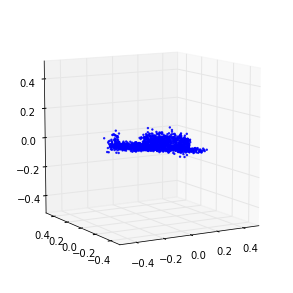

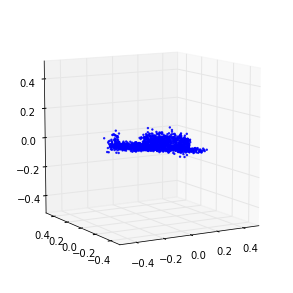

In [45]:
Point_Cloud(ae.reconstruct(train_data.next_batch(1)[0])[0][0]).plot()